In [ ]:
#default_exp cam

<a href="https://colab.research.google.com/github/ai-fast-track/timeseries/blob/master/nbs/82_timeseries_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# hide
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
# hide
from nbdev.showdoc import *

# Model interpretation using CAM and GRAD-CAM
> CAM and GRAD-CAM for univariate time series

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
# !pip install git+https://github.com/fastai/fastai2.git

In [ ]:
# Run this cell to install the latest version of fastcore shared on github
# !pip install git+https://github.com/fastai/fastcore.git

In [ ]:
# Run this cell to install the latest version of timeseries shared on github
# !pip install git+https://github.com/ai-fast-track/timeseries.git

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai2.basics import *
from fastai2.callback.hook import *

In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.cm as cm

In [ ]:
# hide
# Only for Windows users because symlink to `timeseries` folder is not recognized by Windows
import sys
sys.path.append("..")

In [ ]:
from timeseries.all import *

## GunPoint Dataset
> The dataset was obtained by capturing two actors transiting between
yoga poses in front of a green screen. The problem is to
discriminate between one actor (male) and another (female). Each
image was converted to a one dimensional series by finding the
outline and measuring the distance of the outline to the centre.

In [ ]:
dsname =  'GunPoint' # 'ChlorineConcentration', 'Yoga'

In [ ]:
# url = 'http://www.timeseriesclassification.com/Downloads/GunPoint.zip'
path = unzip_data(URLs_TS.UNI_GUN_POINT)
path

Path('/home/farid/.fastai/data/GunPoint')

In [ ]:
fname_train = f'{dsname}_TRAIN.arff'
fname_test = f'{dsname}_TEST.arff'
fnames = [path/fname_train, path/fname_test]
fnames

[Path('/home/farid/.fastai/data/GunPoint/GunPoint_TRAIN.arff'),
 Path('/home/farid/.fastai/data/GunPoint/GunPoint_TEST.arff')]

In [ ]:
data = TSData.from_arff(fnames)
print(data)

TSData:
 Datasets names (concatenated): ['GunPoint_TRAIN', 'GunPoint_TEST']
 Filenames:                     [Path('/home/farid/.fastai/data/GunPoint/GunPoint_TRAIN.arff'), Path('/home/farid/.fastai/data/GunPoint/GunPoint_TEST.arff')]
 Data shape: (200, 1, 150)
 Targets shape: (200,)
 Nb Samples: 200
 Nb Channels:           1
 Sequence Length: 150


In [ ]:
items = data.get_items()

In [ ]:
seed = 42
splits = RandomSplitter(seed=seed)(range_of(items)) #by default 80% for train split and 20% for valid split are chosen 
splits

((#160) [66,176,14,106,71,193,95,16,133,113...],
 (#40) [142,56,198,77,50,55,4,69,174,47...])

In [ ]:
bs = 128                            
# Normalize at batch time
tfm_norm = Normalize(scale_subtype = 'per_sample_per_channel', scale_range=(0, 1)) # per_sample , per_sample_per_channel
# tfm_norm = Standardize(scale_subtype = 'per_sample')
batch_tfms = [tfm_norm]

In [ ]:
default_device()

device(type='cpu')

In [ ]:
# dls = TSDataLoaders.from_files(fnames=fnames, batch_tfms=batch_tfms, num_workers=0, device=default_device())
dls = TSDataLoaders.from_files(fnames=fnames, num_workers=0, device=default_device())

In [ ]:
# dls.show_batch(max_n=9)

## Training Model

In [ ]:
# Number of channels (i.e. dimensions in ARFF and TS files jargon)
c_in = get_n_channels(dls.train) # data.n_channels
# Number of classes
c_out= dls.c 
c_in,c_out

(1, 2)

In [ ]:
model = inception_time(c_in, c_out).to(device=default_device())
model

Sequential(
  (0): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxpool_bottleneck): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (bn_relu): Sequential(
          (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ReLU()
        )
      )
    )
  )
  (1): SequentialEx(
    (layers): ModuleList(
      (0): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), 

In [ ]:
# opt_func = partial(Adam, lr=3e-3, wd=0.01)
#Or use Ranger
def opt_func(p, lr=slice(3e-3)): return Lookahead(RAdam(p, lr=lr, mom=0.95, wd=0.01)) 

In [ ]:
#Learner
loss_func = LabelSmoothingCrossEntropy() 
learn = Learner(dls, model, opt_func=opt_func, loss_func=loss_func, metrics=accuracy)

print(learn.summary())

Sequential (Input shape: ['64 x 1 x 150'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 150        1,248      True      
________________________________________________________________
Conv1d               64 x 32 x 150        608        True      
________________________________________________________________
Conv1d               64 x 32 x 150        288        True      
________________________________________________________________
MaxPool1d            64 x 1 x 150         0          False     
________________________________________________________________
Conv1d               64 x 32 x 150        32         True      
________________________________________________________________
BatchNorm1d          64 x 128 x 150       256        True      
________________________________________________________________
ReLU                 64 x 128 x 150       0          False     
_______________________________________________________

(0.0019054606556892395, 0.00015848931798245758)

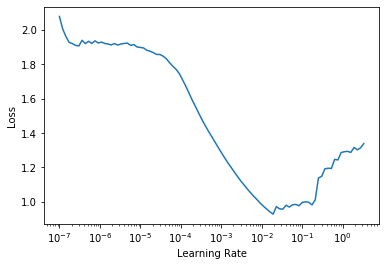

In [ ]:
lr_min, lr_steep = learn.lr_find()
lr_min, lr_steep

In [ ]:
lr_max=1e-3 # lr_max=lr_steep
epochs=30; lr_max=lr_max;  pct_start=.7; moms=(0.95,0.85,0.95); wd=1e-2
learn.fit_one_cycle(epochs, lr_max=lr_max, pct_start=pct_start,  moms=moms, wd=wd)
# learn.fit_one_cycle(epochs, lr_max=lr_steep)

epoch,train_loss,valid_loss,accuracy,time
0,1.999206,0.699122,0.425000,00:01
1,1.891729,0.700134,0.425000,00:01
2,1.793355,0.701314,0.425000,00:01
3,1.744699,0.702305,0.425000,00:01
4,1.672439,0.703361,0.425000,00:01
5,1.564542,0.704968,0.425000,00:01
6,1.471673,0.706403,0.425000,00:01
7,1.342500,0.708061,0.425000,00:02
8,1.219537,0.712081,0.425000,00:02
9,1.124062,0.714671,0.425000,00:02


## Graphs

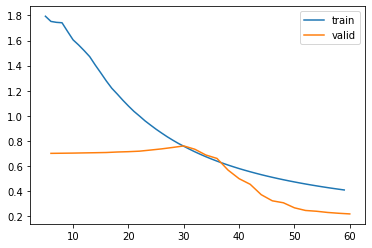

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.show_results(max_n=9)

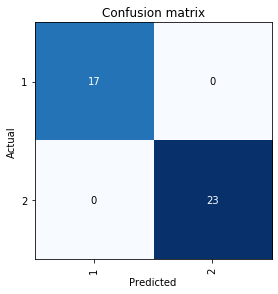

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused()

[]

## Heatmap

In [ ]:
m = learn.model.eval();

In [ ]:
m[5]

SequentialEx(
  (layers): ModuleList(
    (0): InceptionModule(
      (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,))
      (convs): ModuleList(
        (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
        (1): Conv1d(32, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
        (2): Conv1d(32, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
      )
      (maxpool_bottleneck): Sequential(
        (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
        (1): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
      (bn_relu): Sequential(
        (0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (1): ReLU()
      )
    )
    (1): Shortcut(
      (act_fn): ReLU(inplace=True)
      (conv): Conv1d(128, 128, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [ ]:
m[6]

AdaptiveConcatPool1d(
  (ap): AdaptiveAvgPool1d(output_size=1)
  (mp): AdaptiveMaxPool1d(output_size=1)
)

In [ ]:
print(learn.summary())

Sequential (Input shape: ['64 x 1 x 150'])
Layer (type)         Output Shape         Param #    Trainable 
Conv1d               64 x 32 x 150        1,248      True      
________________________________________________________________
Conv1d               64 x 32 x 150        608        True      
________________________________________________________________
Conv1d               64 x 32 x 150        288        True      
________________________________________________________________
MaxPool1d            64 x 1 x 150         0          False     
________________________________________________________________
Conv1d               64 x 32 x 150        32         True      
________________________________________________________________
BatchNorm1d          64 x 128 x 150       256        True      
________________________________________________________________
ReLU                 64 x 128 x 150       0          False     
_______________________________________________________

In [ ]:
#export
def hooked_backward(x, y, model, layer):
    "A function hook to get access to both activation and gradient values of a given `model` at the layer number `layer`"
    xb= x[None, :] # xb = x.unsqueeze()
    with hook_output(model[layer]) as hook_a: 
        with hook_output(m[layer], grad=True) as hook_g:
            preds = m(xb)
            preds[0,int(y)].backward()
    return hook_a,hook_g

In [ ]:
show_doc(hooked_backward)

<h4 id="hooked_backward" class="doc_header"><code>hooked_backward</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hooked_backward</code>(**`x`**, **`y`**, **`model`**, **`layer`**)

A function hook to get access to both activation and gradient values of a given `model` at the layer number `layer`

## Note
> Through the notebook, I will using GunPoint dataset and use its dimensions to illustrate tensors shapes in order to make the code more readable

In [ ]:
#export
def hook_acts(x, y, model, layer):
    "A hook function to get access to activation values of a given `model` at the layer number `layer`"
    hook_a,hook_g = hooked_backward(x, y, model, layer)
    acts  = hook_a.stored[0].cpu()
    return acts

In [ ]:
show_doc(hook_acts)

<h4 id="hook_acts" class="doc_header"><code>hook_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>hook_acts</code>(**`x`**, **`y`**, **`model`**, **`layer`**)

A hook function to get access to activation values of a given `model` at the layer number `layer`

In [ ]:
#export
def cam_acts(x, y, model, layer, reduction='mean', force_scale=True, scale_range=(0, 1)): # x.shape = [1, 150]
    "Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds to       (mean + max)/2"
    acts = hook_acts(x, y, model, layer) # acts.shape = [128, 150]

    if reduction=='mean': acts = acts.mean(0)                  # mean.shape = [150]
    if reduction=='median': acts = acts.median(0).values         # mendia.shape = [150]
    if reduction=='max' : acts = acts.max(0).values      # max.shape = [150]
    if reduction=='mean_max': acts = (acts.mean(0) + acts.max(0).values)/2 # max_mean.shape = [150]
    # print(f'Reduction: {reduction}')

    if force_scale==True:
        acts = (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]
        return acts[None, :] # acts.shape = [1, 150]
    else:
        return acts[None, :] # acts.shape = [1, 150]

# store function name
cam_acts.name = r'CAM'

In [ ]:
show_doc(cam_acts)

<h4 id="cam_acts" class="doc_header"><code>cam_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>cam_acts</code>(**`x`**, **`y`**, **`model`**, **`layer`**, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*)

Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds to       (mean + max)/2

In [ ]:
#export
def acts_scaled(acts, scale_range=(0, 1)):
    "Scale values between [scale_range[0]...scale_range[1]]. By default, it scales `acts` between 0 and 1"
    return (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]    
    

In [ ]:
show_doc(acts_scaled)

<h4 id="acts_scaled" class="doc_header"><code>acts_scaled</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>acts_scaled</code>(**`acts`**, **`scale_range`**=*`(0, 1)`*)

Scale values between [scale_range[0]...scale_range[1]]. By default, it scales `acts` between 0 and 1

In [ ]:
# export
# cmap possible values are: 

# Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r

In [ ]:
#export
def grad_cam_acts(x, y, model, layer, reduction='mean', force_scale=True, scale_range=(0, 1)): # x.shape = [1, 150]
    "Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds       to (mean + max)/2" 
    hook_a,hook_g = hooked_backward(x, y, model, layer)
    
    acts  = hook_a.stored[0].cpu()      # acts.shape = [128, 150]
    grad = hook_g.stored[0][0].cpu()    # grad.shape = [128, 150]

    # grad_chan.shape = [128]
    if reduction=='mean': grad_chan = grad.mean(1)
    if reduction=='median': grad_chan = grad.median(1).values
    if reduction=='max': grad_chan = grad.max(1).values
    if reduction=='mean_max': grad_chan = (grad.mean(1) + grad.max(1).values)/2
    # print(f'Reduction: {reduction}')
    
    mult = (acts*grad_chan[..., None])  # shape grad_chan[..., None] => [128, 1] => broadcast to => [128, 150]
    acts = mult.mean(0)                 # mean.shape = [150]
        
    if force_scale==True:
        acts = (acts - acts.min())/(acts.max() - acts.min())*(scale_range[1] - scale_range[0]) + scale_range[0]
        return acts[None, :]    # acts.shape = [1, 150]
    else:
        return acts[None, :]    # acts.shape = [1, 150]       

# store function name
grad_cam_acts.name = r'GRAD-CAM'

In [ ]:
show_doc(grad_cam_acts)

<h4 id="grad_cam_acts" class="doc_header"><code>grad_cam_acts</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>grad_cam_acts</code>(**`x`**, **`y`**, **`model`**, **`layer`**, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*)

Compute raw CAM values. `reduction` : string. One of ['mean', 'median', 'max', 'mean_max']. 'mean_max' corresponds       to (mean + max)/2

In [ ]:
#export
@delegates(LineCollection.__init__)
def CAM_batch_compute(b, model, layer=5, func_cam=grad_cam_acts, reduction='mean', force_scale=True, scale_range=(0, 1),**kwargs):
      
    'Compute either CAM for a list (b) of time series `tseries` .'
  
    ts_min_max = [1e10, -1e10]
    acts_min_max = [1e10, -1e10]
    tseries_list = []
    y_list = []
    acts_list = []
    idx = 1   
    # Compute activation for each time series `tseries` here below
    # Process one time series at the time
    for item in b:
        # print(f'idx = {idx}')
        tseries, y = item
        y_list.append(y)        
        acts = func_cam(tseries, y, m, layer=layer, reduction=reduction, force_scale=force_scale, scale_range=scale_range)

        # remove the first dimension : [1, 150] -> [150]
        acts = acts.squeeze().numpy()
        tseries = tseries.squeeze().numpy()

        tseries_list.append(tseries)
        acts_list.append(acts)
        
        # set `tseries min and max
        min, max = tseries.min(), tseries.max()
        # print('min - max', min, max)
        if min<ts_min_max[0]: ts_min_max[0] = min
        if max>ts_min_max[1]: ts_min_max[1] = max
        # print('tsmin - tsmax', ts_min_max[0], ts_min_max[1])
        
        # set `tseries min and max
        min, max = acts.min(), acts.max()
        # print('min - max', min, max)
        if min<acts_min_max[0]: acts_min_max[0] = min
        if max>acts_min_max[1]: acts_min_max[1] = max
        # print('actsmin - actsmax', acts_min_max[0], acts_min_max[1])
        
        idx += 1

    return (tseries_list, acts_list, y_list, ts_min_max, acts_min_max)


In [ ]:
def _listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    # if is_iter(o): return list(o)
    return [o]

In [ ]:
#export
def batchify(dataset, idxs): 
    'Return a list of items for the supplied dataset and idxs'
    tss = [dataset[i][0] for i in idxs]
    ys  = [dataset[i][1] for i in idxs]
    return (tss, ys)

In [ ]:
#export
def debatchify(batch):
    'Return a batch of items for the supplied dataset and idxs'
    tss, ys = batch
    b = [(ts, y) for ts,y in zip(tss, ys)]

In [ ]:
#export
@delegates(LineCollection.__init__)
def CAM_batch_plot_one_fig(b, model, layer=5, func_cam=grad_cam_acts, reduction='mean', force_scale=True, scale_range=(0, 1),                         cmap="Spectral_r", linewidth=4, linestyles='solid', alpha=1.0, scatter=False, i2o=noop, figsize=(6,4),                        **kwargs):
    
    'Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the   scaled CAM values. The time series are plot on a single figure'

    """
    linestyles : string, tuple, optional
            Either one of [ 'solid' | 'dashed' | 'dashdot' | 'dotted' ], or
            a dash tuple. The dash tuple is:(offset, onoffseq)
            where ``onoffseq`` is an even length tuple of on and off ink in points.
    """
    
    plt.figure(figsize=figsize)
    
    # This allows to consum either a list of items or a single item 
    b = _listify(b)    
    tseries_list, acts_list, y_list, ts_min_max, acts_min_max = CAM_batch_compute(b, model, layer=layer, func_cam=func_cam,                                              reduction=reduction, force_scale=force_scale, scale_range=scale_range, **kwargs)  
 
    levels = 254
    cmap = plt.get_cmap(cmap, lut=levels) #seismic
    if force_scale==True:
        colors = cmap(np.linspace(scale_range[0], scale_range[1], levels))
        norm = BoundaryNorm(np.linspace(scale_range[0], scale_range[1], levels+1), len(colors))
    else:
        colors = cmap(np.linspace(acts_min_max[0], acts_min_max[1], levels))
        norm = BoundaryNorm(np.linspace(acts_min_max[0], acts_min_max[1], levels+1), len(colors))

    # Plot activation `acts` (superimposed on the original time series `tseries)
    idx = 1
    for tseries, acts, y in zip(tseries_list, acts_list, y_list):
        t = np.arange(tseries.shape[-1])
        if scatter==True:
            # plt.figure(figsize=(13,4))
            # plt.subplot(1, 2, idx) 
            plt.scatter(t, tseries, cmap=cmap, c = acts, linewidths=linewidth )
            idx += 1
        else:
            points = np.array([t, tseries]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            if idx==2: linestyles='dashed'
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth, linestyles=linestyles, alpha=alpha,                                    **kwargs )
            lc.set_array(acts)
            lc.set_linewidth(linewidth)
            plt.gca().add_collection(lc)
            idx += 1 

    plt.xlim(t.min(), t.max())
    plt.ylim(ts_min_max[0]*1.2, ts_min_max[1]*1.2)

    titles = [i2o(y) for y in y_list]
    title = ' - '.join(titles)
    if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
    title =  f'[{title}] - {func_cam.name} - {reduction}'
    # print(f'Title: {title}')
    plt.title(title)   
    
    scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
    scalarmappaple.set_array(acts)
    plt.colorbar(scalarmappaple)
    plt.show()

In [ ]:
show_doc(CAM_batch_plot_one_fig)

<h4 id="CAM_batch_plot_one_fig" class="doc_header"><code>CAM_batch_plot_one_fig</code><a href="__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>CAM_batch_plot_one_fig</code>(**`b`**, **`model`**, **`layer`**=*`5`*, **`func_cam`**=*`'grad_cam_acts'`*, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*, **`cmap`**=*`'Spectral_r'`*, **`linewidth`**=*`4`*, **`linestyles`**=*`'solid'`*, **`alpha`**=*`1.0`*, **`scatter`**=*`False`*, **`i2o`**=*`'noop'`*, **`figsize`**=*`(6, 4)`*, **`linewidths`**=*`None`*, **`colors`**=*`None`*, **`antialiaseds`**=*`None`*, **`offsets`**=*`None`*, **`transOffset`**=*`None`*, **`norm`**=*`None`*, **`pickradius`**=*`5`*, **`zorder`**=*`2`*, **`facecolors`**=*`'none'`*)

Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the   scaled CAM values. The time series are plot on a single figure

In [ ]:
#export

# def CAM_batch_plot_multi_fig(b, model, layer=5, func_cam=grad_cam_acts, reduction='mean', cmap="Spectral_r", linewidth=4,                                       linestyles='solid', alpha=1.0, scatter=False, i2o=noop, figsize=(13,4), **kwargs):
@delegates(LineCollection.__init__)
def CAM_batch_plot_multi_fig(b, model, layer=5, func_cam=grad_cam_acts, reduction='mean',force_scale=True, scale_range=(0, 1),                        cmap="Spectral_r", linewidth=4, linestyles='solid', alpha=1.0, scatter=False, i2o=noop, figsize=(13,4),                        **kwargs):    
    'Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the        scaled CAM values. Each time series is plotted on a separate figure'

    # This allows to consum either a list of items or a single item 
    b = _listify(b)
    tseries_list, acts_list, y_list, ts_min_max, acts_min_max = CAM_batch_compute(b, model, layer=layer, func_cam=func_cam,                                              reduction=reduction, force_scale=force_scale, scale_range=scale_range, **kwargs)  
    levels = 254
    cmap = plt.get_cmap(cmap, lut=levels) #seismic
    if force_scale==True:
        colors = cmap(np.linspace(scale_range[0], scale_range[1], levels))
        norm = BoundaryNorm(np.linspace(scale_range[0], scale_range[1], levels+1), len(colors))
    else:
        colors = cmap(np.linspace(acts_min_max[0], acts_min_max[1], levels))
        norm = BoundaryNorm(np.linspace(acts_min_max[0], acts_min_max[1], levels+1), len(colors))

    # Plot activation `acts` (superimposed on the original time series `tseries)
    idx = 1
    for tseries, acts, y in zip(tseries_list, acts_list, y_list):
        t = np.arange(tseries.shape[-1])
        if scatter==True:
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, idx) 
            plt.scatter(t, tseries, cmap=cmap, c = acts)
            title = i2o(y)
            if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
            title =  f'[{title}] - {func_cam.name} - {reduction}'
            scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
            scalarmappaple.set_array(acts)
            plt.colorbar(scalarmappaple)
            plt.show()
            idx += 1
        else:
            points = np.array([t, tseries]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, idx) # sharey='row'
            lc = LineCollection(segments, cmap=cmap, norm=norm, linewidth=linewidth, linestyles=linestyles, alpha=alpha,                                    **kwargs )
            lc.set_array(acts)
            lc.set_linewidth(linewidth)
            plt.gca().add_collection(lc)

            title = i2o(y)
            if not hasattr(func_cam, 'name'): func_cam.name = str(func_cam)
            title =  f'[{title}] - {func_cam.name} - {reduction}'

            plt.xlim(t.min(), t.max())
            plt.ylim(ts_min_max[0]*1.2, ts_min_max[1]*1.2)
            plt.title(title)
            scalarmappaple = cm.ScalarMappable(norm=norm, cmap=cmap)
            scalarmappaple.set_array(acts)
            plt.colorbar(scalarmappaple)
            plt.show()
            idx += 1        

In [ ]:
show_doc(CAM_batch_plot_multi_fig)

<h4 id="CAM_batch_plot_multi_fig" class="doc_header"><code>CAM_batch_plot_multi_fig</code><a href="__main__.py#L4" class="source_link" style="float:right">[source]</a></h4>

> <code>CAM_batch_plot_multi_fig</code>(**`b`**, **`model`**, **`layer`**=*`5`*, **`func_cam`**=*`'grad_cam_acts'`*, **`reduction`**=*`'mean'`*, **`force_scale`**=*`True`*, **`scale_range`**=*`(0, 1)`*, **`cmap`**=*`'Spectral_r'`*, **`linewidth`**=*`4`*, **`linestyles`**=*`'solid'`*, **`alpha`**=*`1.0`*, **`scatter`**=*`False`*, **`i2o`**=*`'noop'`*, **`figsize`**=*`(13, 4)`*, **`linewidths`**=*`None`*, **`colors`**=*`None`*, **`antialiaseds`**=*`None`*, **`offsets`**=*`None`*, **`transOffset`**=*`None`*, **`norm`**=*`None`*, **`pickradius`**=*`5`*, **`zorder`**=*`2`*, **`facecolors`**=*`'none'`*)

Compute CAM using `func_cam` function, and plot a batch of colored time series `tseries`. The colors correspond to the        scaled CAM values. Each time series is plotted on a separate figure

In [ ]:
dls.vocab

(#2) ['1','2']

In [ ]:
# export
# Example of i2o() function
# Converting CategoryTensor label into the human-readable label
lbl_dict = dict([
    (0, 'Gun'),   
    (1, 'Point')]
)
def i2o(y):
    return lbl_dict.__getitem__(y.data.item())
    # return lbl_dict.__getitem__(int(dls.tfms[1][1].decodes(y)))

In [ ]:
# x1 correspond to Gun
x1, y1 = dls.train.dataset[0]
x1.shape,y1

(torch.Size([1, 150]), TensorCategory(0))

In [ ]:
x1

TensorTS([[-0.6029, -0.6026, -0.6015, -0.6017, -0.6001, -0.5971, -0.5969, -0.5967,
         -0.5989, -0.5982, -0.5980, -0.5975, -0.5954, -0.5973, -0.5926, -0.5877,
         -0.5867, -0.5845, -0.5827, -0.5834, -0.5836, -0.5843, -0.5837, -0.5826,
         -0.5847, -0.5844, -0.5832, -0.5829, -0.5835, -0.5841, -0.5802, -0.5598,
         -0.5372, -0.5194, -0.5131, -0.5119, -0.5240, -0.5474, -0.5717, -0.5778,
         -0.5745, -0.5560, -0.5241, -0.5013, -0.4591, -0.4084, -0.3357, -0.2329,
         -0.1382,  0.0548,  0.2929,  0.4062,  0.6587,  0.8967,  1.1368,  1.3721,
          1.5708,  1.7629,  1.8698,  1.9778,  1.9928,  2.0151,  2.0318,  2.0364,
          2.0408,  2.0400,  2.0472,  2.0440,  2.0450,  2.0503,  2.0475,  2.0473,
          2.0498,  2.0530,  2.0429,  2.0214,  2.0214,  1.9742,  1.9128,  1.8068,
          1.6602,  1.5266,  1.3651,  1.2026,  1.0339,  0.8960,  0.7388,  0.6017,
          0.4597,  0.3081,  0.1812,  0.0638, -0.0471, -0.1335, -0.2083, -0.2843,
         -0.3542, -0.4056,

In [ ]:
y1.data.item()

0

In [ ]:
# x2 corresponds to Point
x2, y2 = dls.train.dataset[3]
x2.shape, y2

(torch.Size([1, 150]), TensorCategory(1))

In [ ]:
i2o(y1), i2o(y2)

('Gun', 'Point')

In [ ]:
dls.tfms[1][1].decodes(y1)

'1'

In [ ]:
# len((m.layers))

## How to build a list of items to feed to the `cam_plot`

In [ ]:
# export
def get_batch(dataset, idxs): 
    'Return a list of items for the supplied dataset and idxs'
    b = [dataset[i] for i in idxs]
    return b

In [ ]:
idxs = [0,3]
b = get_batch(dls.train.dataset, idxs)
len(b), type(b)

(2, list)

In [ ]:
test_eq(len(b), 2)
test_eq(isinstance(b, list), True)
test_eq(isinstance(b, tuple), False)

## Plotting CAM for several dataset items in one shared figure 
> Example: the function expects a list of `items` and plots CAM for the provided items list. In this example, `reduction='max'`

### Using raw activation values (Non-scaled values)
By default, both `func_cam=grad_cam_acts` (GRAD-CAM) and `reduction=mean` are used
In this example, we are plotting the raw activation values (by default GRAD-CAM). Notice the values on the cmap color palette.
> We can supply a user-defined `func_cam`. See here below an example with a custom defined function `cam_acts_1`

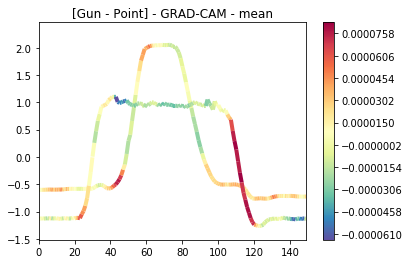

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, force_scale=False)

### Using Scaled activation values
In this example, we are plotting the raw activation values (by default GRAD-CAM). Notice the values on the cmap color palette bounds: [0..1]. This scale range is the default one. We can supply the argument `scale_range=(0,2)` for example to provide user-defined range

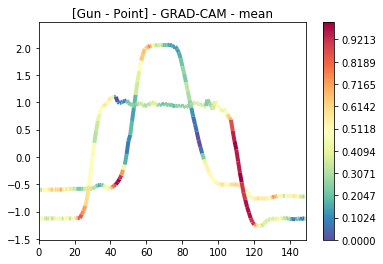

In [ ]:
# Gun - Point - CAM - mean
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o)

### Using `reduction='max'` instead of the default `reduction='mean'`

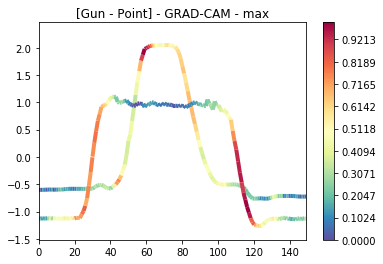

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=grad_cam_acts, i2o=i2o, reduction='max')

### Plotting scattered lines

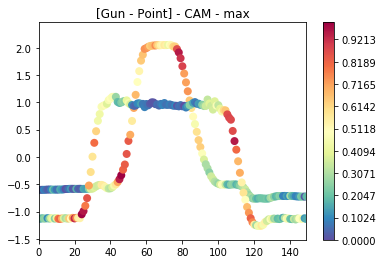

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='max', linewidth=2, scatter=True)

## Plotting CAM for a single dataset item 
> Example using `func_cam=cam_acts` (CAM) function, `reduction='max'`, a different color map `cmap='hot'`,

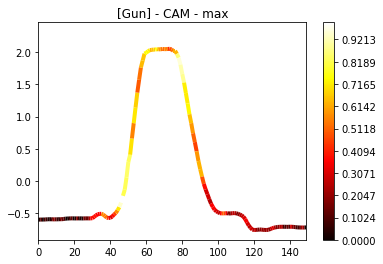

In [ ]:
# dls.train.dataset[0]
# Gun - CAM - max
CAM_batch_plot_one_fig(dls.train.dataset[0], m, 5, func_cam=cam_acts, i2o=i2o, reduction='max', cmap='hot', scatter=False)

## Creating a separate figure for each item 
> Each item CAM is plotted in a separate figure. Example using `func_cam=cam_acts` (CAM) function, `reduction='max'`

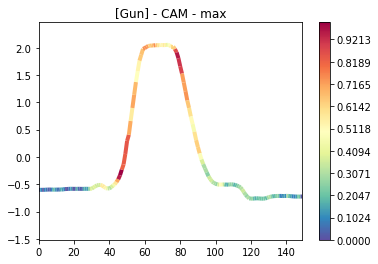

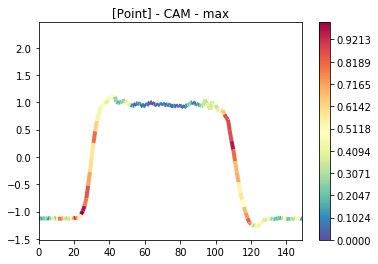

In [ ]:
# Gun - CAM - max
CAM_batch_plot_multi_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='max', scatter=False)

## Using different cmap

**cmap possible values are: **
`
Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, winter, winter_r
`

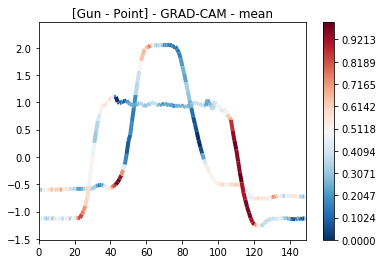

In [ ]:
# Gun - Point - GRAD-CAM - mean
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, cmap='RdBu_r')

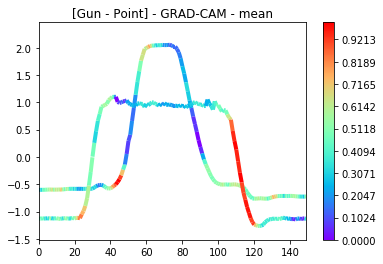

In [ ]:
# Gun - Point - GRAD-CAM - mean
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, cmap='rainbow') # twilight rainbow

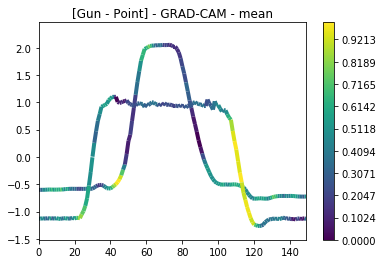

In [ ]:
# Gun - Point - GRAD-CAM - mean
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, cmap='viridis') # twilight rainbow

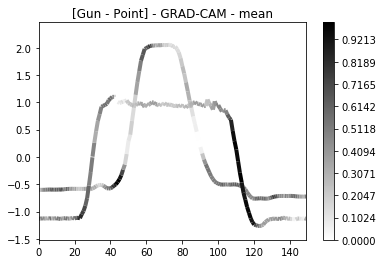

In [ ]:
# Gun - Point - GRAD-CAM - mean
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, cmap='gist_gray_r') # twilight rainbow

## Using different line styles
> line styles : [ 'solid' | 'dashed' | 'dashdot' | 'dotted' ]

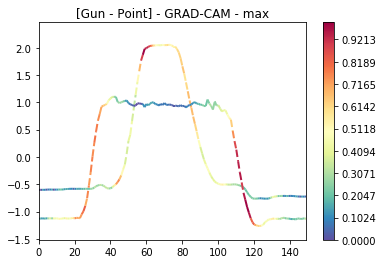

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, reduction='max', linewidth=2, linestyles='dashed')

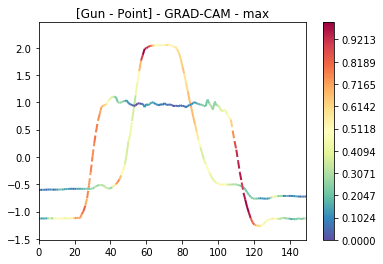

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, reduction='max', linewidth=2, linestyles='dashdot')

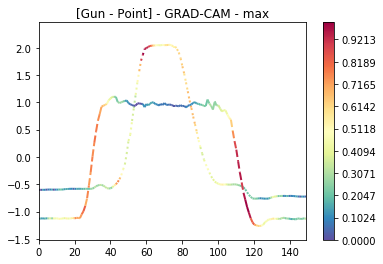

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, i2o=i2o, reduction='max', linewidth=2, linestyles='dotted')

## How to use your customized CAM function
> The user can create their own CAM function. Check out how both `cam_acts` and `grad_acts_cam` are define here above. Here below, as an illustration, we create a partial function that used `cam_acts` function

In [ ]:
#Example using a partial
cam_acts_1 = partial(cam_acts, force_scale=False, scale_range=(0,2))
cam_acts_1.name = r'cam_acts_1'

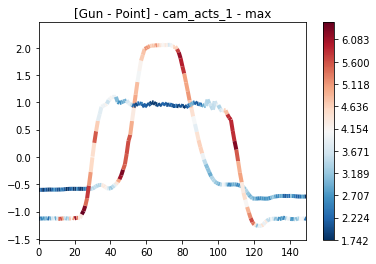

In [ ]:
# Gun - CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts_1, i2o=i2o, reduction='max', cmap='RdBu_r', force_scale=False, scale_range=(0,2), linewidth=4, figsize=(6,4), scatter=False)

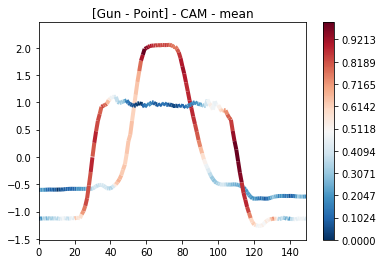

In [ ]:
# RdBu_r GnBu_r
# Gun - Point- CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='mean', cmap='RdBu_r', linewidth=4, figsize=(6,4), scatter=False)

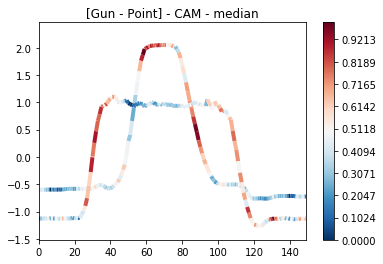

In [ ]:
# RdBu_r GnBu_r
# Gun - Point- CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='median', cmap='RdBu_r', linewidth=4, figsize=(6,4), scatter=False)

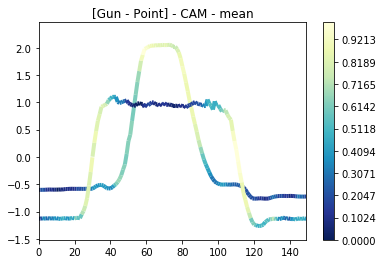

In [ ]:
# RdBu_r GnBu_r
# Gun - Point- CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='mean', cmap='YlGnBu_r', linewidth=4, figsize=(6,4), scatter=False)

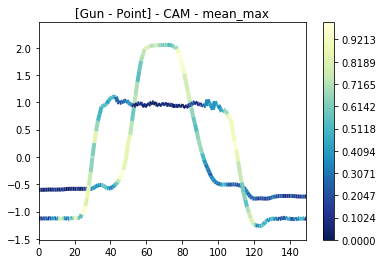

In [ ]:
# RdBu_r GnBu_r
# Gun - Point- CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='mean_max', cmap='YlGnBu_r', linewidth=4, figsize=(6,4), scatter=False)

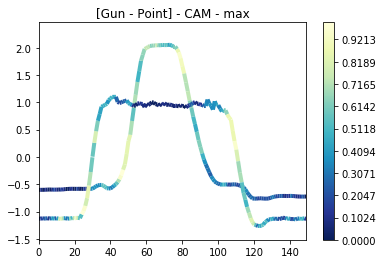

In [ ]:
# RdBu_r, GnBu_r, YlGnBu_r
# Gun - Point- CAM - max
CAM_batch_plot_one_fig(b, m, 5, func_cam=cam_acts, i2o=i2o, reduction='max', cmap='YlGnBu_r', linewidth=4, figsize=(6,4), scatter=False)

In [ ]:
batch = dls.one_batch()
type(batch), len(batch), type(batch[0])

(tuple, 2, timeseries.core.TensorTS)

In [ ]:
type(batch[0]), batch[0]

(timeseries.core.TensorTS,
 TensorTS([[[-0.5448, -0.5449, -0.5438,  ..., -0.6358, -0.6339, -0.6339]],
 
         [[-1.4143, -1.4154, -1.4163,  ..., -1.4537, -1.4567, -1.4546]],
 
         [[-0.6724, -0.6707, -0.6713,  ..., -0.5637, -0.5622, -0.5632]],
 
         ...,
 
         [[-0.7168, -0.7131, -0.7101,  ..., -0.5704, -0.5690, -0.5664]],
 
         [[-1.1871, -1.1905, -1.1904,  ..., -1.1470, -1.1459, -1.1484]],
 
         [[-0.9289, -0.9266, -0.9262,  ..., -0.9456, -0.9464, -0.9461]]]))

In [ ]:
batch[0][0]

tensor([[-0.5448, -0.5449, -0.5438, -0.5437, -0.5445, -0.5448, -0.5442, -0.5468,
         -0.5459, -0.5463, -0.5464, -0.5500, -0.5491, -0.5478, -0.5441, -0.5470,
         -0.5448, -0.5479, -0.5478, -0.5500, -0.5501, -0.5531, -0.5527, -0.5532,
         -0.5529, -0.5536, -0.5517, -0.5521, -0.5495, -0.5498, -0.5481, -0.5455,
         -0.5443, -0.5457, -0.5458, -0.5461, -0.5455, -0.5457, -0.5448, -0.5456,
         -0.5426, -0.5410, -0.5384, -0.5191, -0.4784, -0.4184, -0.3388, -0.1963,
         -0.3003,  0.0182,  0.1610,  0.2327,  0.3824,  0.5068,  0.6917,  0.9230,
          1.2067,  1.4669,  1.7163,  1.8704,  1.9482,  1.9830,  2.0024,  2.0207,
          2.0351,  2.0362,  2.0429,  2.0506,  2.0709,  2.0551,  2.0572,  2.0637,
          2.0698,  2.0731,  2.0773,  2.0730,  2.0730,  2.0704,  2.0608,  2.0392,
          1.9637,  1.8303,  1.6428,  1.4401,  1.2646,  1.0866,  0.8965,  0.6383,
          0.5498,  0.4797,  0.2032, -0.0311, -0.2693, -0.4028, -0.5282, -0.6257,
         -0.7065, -0.7506, -

In [ ]:
type(batch[1]), batch[1]

(fastai2.torch_core.TensorCategory,
 TensorCategory([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0,
         0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1,
         1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1]))

In [ ]:
batch

(TensorTS([[[-1.4817, -1.4829, -1.4832,  ..., -1.3739, -1.3738, -1.3747]],
 
         [[-0.5463, -0.5486, -0.5496,  ..., -0.6520, -0.6515, -0.6537]],
 
         [[-0.9811, -0.9791, -0.9776,  ..., -0.9693, -0.9704, -0.9705]],
 
         ...,
 
         [[-0.5864, -0.5829, -0.5781,  ..., -0.6171, -0.6190, -0.6219]],
 
         [[-0.6479, -0.6420, -0.6382,  ..., -0.6404, -0.6387, -0.6387]],
 
         [[-1.0925, -1.0926, -1.0908,  ..., -1.1809, -1.1709, -1.1547]]]),
 TensorCategory([1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1,
         1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
         0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0]))

## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
# notebook2script(fname='82_timeseries_CAM.ipynb')

Converted 80_timeseries_data.ipynb.
Converted 81_timeseries_core.ipynb.
Converted 82_univariate_timeseries_CAM.ipynb.
Converted Colab_timeseries_Tutorial.ipynb.
Converted index.ipynb.
Converted training_using_default_settings.ipynb.
Converted univariate_timeseries_Tutorial.ipynb.


![](images/montreal-pont-jacques-cartier.jpg)